In [1]:
## IMPORT RELEVANT LIBRARIES
import time
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.optim import lr_scheduler

In [15]:
### training parameters
SHOW_SAMPLES = True
BATCH_SIZE = 64
NUM_CLASSES = 10
LEARNING_RATE = 3e-4
NUM_EPOCHS = 25
PRINT_INTERVAL = 200*(32/BATCH_SIZE) ## frequency of prining training stats
VAL_INTERVAL = 400*(32/BATCH_SIZE) ### frequency of validation in terms of train iterations
SMOOTHING_FACTOR = 0.90 ### for prining the running loss
OPTIMIZER = "adam" ### adam or SGD
LOSS_FUNCTION = "CrossEntropy" ## KLDivergence or CrossEntropy
DATA_AUGMENTATION = False
LR_SCHEDULER = False

In [3]:
### DATA LOADING
### statistics for the CIFAR10 dataset
torch.manual_seed(0)

cifar_mean, cifar_std = [0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]
### cifar
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

if(not DATA_AUGMENTATION):
  transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize(mean=cifar_mean, std = cifar_std)]) 
else:
  transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.25), 
                                  transforms.RandomVerticalFlip(p=0.25),
                                  transforms.RandomRotation(degrees=(-30,30)),
                                  transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 0.25)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=cifar_mean, std=cifar_std)])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False)

100%|██████████| 170498071/170498071 [00:10<00:00, 15791221.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Images: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])


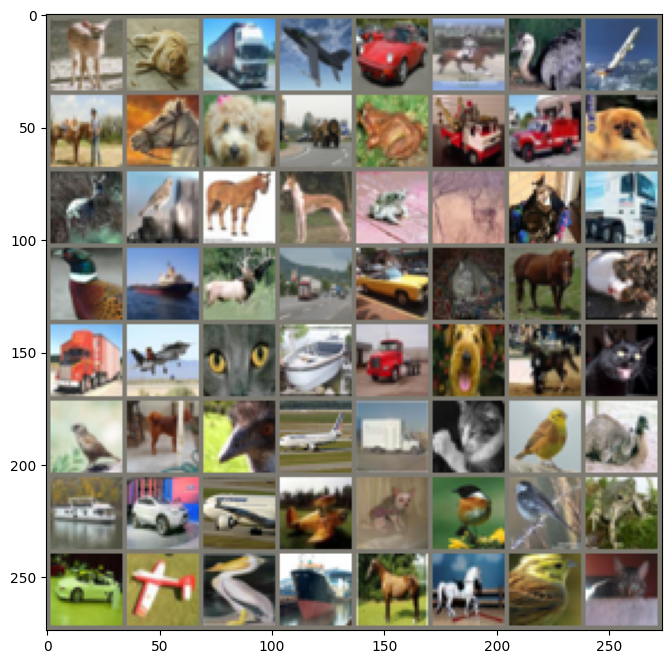

deer cat truck plane car horse bird plane horse horse dog truck frog truck truck dog deer bird horse dog frog deer cat truck bird ship deer truck car cat horse cat truck plane cat ship truck dog horse cat bird dog bird plane truck cat bird bird ship car plane plane dog bird bird frog car plane bird ship horse horse bird cat


In [4]:
### Show Image Samples

def imshow(img):
    plt.figure(figsize=(12,8))
    npimg = img.numpy()
    npimg = npimg * np.array(cifar_std).reshape(-1,1,1) + np.array(cifar_mean).reshape(-1,1,1) ### un-normalize
    plt.imshow(np.transpose(npimg, (1, 2, 0))) ### to put channels last according to matplotlib
    plt.show()
    
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f"Images: {images.shape}, Labels: {labels.shape}") ### B * C * H * W, B

if SHOW_SAMPLES:
    imshow(torchvision.utils.make_grid(images))
    print(" ".join([classes[j] for j in labels]))

In [16]:
## NETWORK CONFIG

from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

class ConvNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=(3,3), stride=1, padding="same"), ### 96 * 32 *32
            nn.ReLU(),
            nn.Conv2d(in_channels=96, out_channels=96, kernel_size=(3,3), stride=1, padding="same"), ### 96 * 32 *32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)), ### 96 * 16  *16
            nn.BatchNorm2d(96)
        )
        self.seq2 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3,3), stride=1, padding="valid"), ### 192 * 14  *14
            nn.ReLU(),
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=(3,3), stride=1, padding="valid"), ### 192 * 12  *12
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2)), ## 192 * 6 * 6  
            nn.BatchNorm2d(192),
          )  
        self.seq3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=10, kernel_size=(1,1), stride=1, padding="same"), ## 10 * 6 * 6
            nn.ReLU(),
        )
        self.seq4 = nn.Sequential(
            nn.Dropout(p=0.20),
            nn.Linear(in_features=360, out_features = 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.20),
            nn.Linear(64, 10),
        )
        
    def forward(self, x):
        x = self.seq1(x)
        x = self.seq2(x)
        x = self.seq3(x)
        x = x.reshape(-1, 360)
        x = self.seq4(x)

        return x

count_parameters(ConvNet())

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
| seq1.0.weight |    2592    |
|  seq1.0.bias  |     96     |
| seq1.2.weight |   82944    |
|  seq1.2.bias  |     96     |
| seq1.5.weight |     96     |
|  seq1.5.bias  |     96     |
| seq2.0.weight |   165888   |
|  seq2.0.bias  |    192     |
| seq2.2.weight |   331776   |
|  seq2.2.bias  |    192     |
| seq2.5.weight |    192     |
|  seq2.5.bias  |    192     |
| seq3.0.weight |    1920    |
|  seq3.0.bias  |     10     |
| seq4.1.weight |   23040    |
|  seq4.1.bias  |     64     |
| seq4.3.weight |     64     |
|  seq4.3.bias  |     64     |
| seq4.5.weight |    640     |
|  seq4.5.bias  |     10     |
+---------------+------------+
Total Trainable Params: 610164


610164

In [17]:
### initialize model, optimizers and the loss function and settup GPU 

model = ConvNet()

## LOSS FUNCTION
if(LOSS_FUNCTION == "KLDivergence"):
  criterion = nn.KLDivLoss(reduction = "batchmean")
elif(LOSS_FUNCTION == "CrossEntropy"):
  criterion = nn.CrossEntropyLoss()
else:
  raise ValueError("LOSS FUNCTION has to be one of KLDivergence | CrossEntropy")

## OPTIMIZER
if (OPTIMIZER == "SGD"):
  optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
elif (OPTIMIZER == "adam"):
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08)
else:
  raise ValueError("Optimizer has to be one of SGD | Adam")

### scheduling algorithm
if(LR_SCHEDULER):
  scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.75, verbose=True)
else:
  ## has effect of no scheduling
  scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=1, verbose=True)

is_cuda = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(is_cuda)
print(device)
model.to(device)

Adjusting learning rate of group 0 to 3.0000e-04.
cuda


ConvNet(
  (seq1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (seq2): Sequential(
    (0): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (seq3): Sequential(
    (0): Conv2d(192, 10, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (seq4): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=360, ou

In [18]:
### TRAINING LOOP
start = time.time()
smooth_training_loss_list_per_iteration = [] ## batch loss after every update
training_loss_list_per_iteration = []
validaton_loss_list_per_iteration = [] ## average validation loss after every VAL_INTERVAL updates
validation_accuracy_per_iteration = []
val_iterations = []
training_accuracy_vs_epoch = []
total_iterations  = 0

for epoch in range(NUM_EPOCHS):
    
    training_running_loss, training_correct = 0.0, 0
    model.train()
    for batch_idx, data in enumerate(trainloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(images)
        if(LOSS_FUNCTION == "CrossEntropy"):
          loss = criterion(logits, labels)
        elif(LOSS_FUNCTION == "KLDivergence"):
          smoothened_target = F.one_hot(labels, num_classes=NUM_CLASSES)*.99 + .001 * torch.ones((labels.shape[0], NUM_CLASSES), device=device)
          loss = criterion(F.log_softmax(logits, dim=1), smoothened_target)

        loss.backward()
        optimizer.step()
        training_running_loss = (loss.item()) if batch_idx == 0 else (loss.item() * (1-SMOOTHING_FACTOR) + SMOOTHING_FACTOR*training_running_loss)
        training_correct += torch.sum(torch.argmax(logits, dim=1) == labels).item()
        smooth_training_loss_list_per_iteration.append(training_running_loss)
        training_loss_list_per_iteration.append(loss.item())
        total_iterations += 1

        if( batch_idx % PRINT_INTERVAL == PRINT_INTERVAL-1 ):
            print(f"\r[TRAIN STAT] Epoch:Iter => {epoch+1}:{batch_idx+1:05} | Running Loss => {training_running_loss:.3f}")
        
        ### TESTING ACCURACY & LOSS
        model.eval()
        if(total_iterations % VAL_INTERVAL == VAL_INTERVAL - 1):
          # print("Validation ... ")
          testing_correct = 0.0
          temp_list = []
          for batch_idx, data in enumerate(testloader):
              images, labels = data
              images, labels = images.to(device), labels.to(device)
              logits = model(images)
              if(LOSS_FUNCTION == "CrossEntropy"):
                loss = criterion(logits, labels)
              elif(LOSS_FUNCTION == "KLDivergence"):
                smoothened_target = F.one_hot(labels, num_classes=NUM_CLASSES)*.99 + .001 * torch.ones((labels.shape[0], NUM_CLASSES), device=device)
                loss = criterion(F.log_softmax(logits, dim=1), smoothened_target)
              temp_list.append(loss.item())
              testing_correct += torch.sum(torch.argmax(logits, dim=1) == labels).item()

          validaton_loss_list_per_iteration.append(sum(temp_list)/len(temp_list))
          validation_accuracy_per_iteration.append(testing_correct/len(testset)*100)
          val_iterations.append(total_iterations)
    
    scheduler.step()

    model.eval()
    training_correct = 0 
    for batch_idx, data in enumerate(trainloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        training_correct += torch.sum(torch.argmax(logits, dim=1) == labels).item()
    training_accuracy_vs_epoch.append(training_correct/len(trainset)*100)
    print(f"Epoch: {epoch+1} END | TRAINING ACCURACY: {training_correct/len(trainset)*100:.2f}% | TESTING ACCURACY: {testing_correct/len(testset)*100:.2f}%")

end = time.time()
print(f"Time Taken {(end-start):.2f} seconds")
print("Finished Training ... ")

[TRAIN STAT] Epoch:Iter => 1:00100 | Running Loss => 2.054
[TRAIN STAT] Epoch:Iter => 1:00200 | Running Loss => 1.882
[TRAIN STAT] Epoch:Iter => 1:00300 | Running Loss => 1.708
[TRAIN STAT] Epoch:Iter => 1:00400 | Running Loss => 1.607
[TRAIN STAT] Epoch:Iter => 1:00500 | Running Loss => 1.572
[TRAIN STAT] Epoch:Iter => 1:00600 | Running Loss => 1.482
[TRAIN STAT] Epoch:Iter => 1:00700 | Running Loss => 1.401
Adjusting learning rate of group 0 to 3.0000e-04.
Epoch: 1 END | TRAINING ACCURACY: 50.95% | TESTING ACCURACY: 46.47%
[TRAIN STAT] Epoch:Iter => 2:00100 | Running Loss => 1.403
[TRAIN STAT] Epoch:Iter => 2:00200 | Running Loss => 1.323
[TRAIN STAT] Epoch:Iter => 2:00300 | Running Loss => 1.193
[TRAIN STAT] Epoch:Iter => 2:00400 | Running Loss => 1.254
[TRAIN STAT] Epoch:Iter => 2:00500 | Running Loss => 1.167
[TRAIN STAT] Epoch:Iter => 2:00600 | Running Loss => 1.221
[TRAIN STAT] Epoch:Iter => 2:00700 | Running Loss => 1.137
Adjusting learning rate of group 0 to 3.0000e-04.
Epoch:

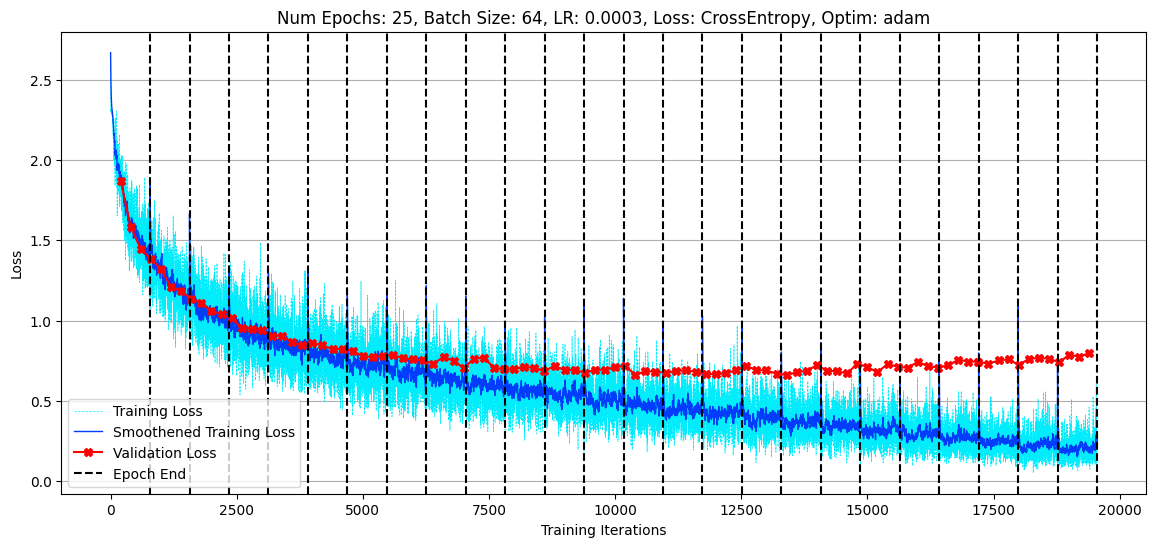

In [19]:
### PLOTS
plt.figure(figsize=(14, 6))
plt.plot(training_loss_list_per_iteration, label="Training Loss", color = "#03ecfc", lw = 0.5, ls="--")
plt.plot(smooth_training_loss_list_per_iteration, label = "Smoothened Training Loss", color = "#033dfc", lw=1)
plt.plot(val_iterations, validaton_loss_list_per_iteration , label="Validation Loss", marker = "X", color="red")
for i in range(NUM_EPOCHS):
  label = ("Epoch End" if i == NUM_EPOCHS - 1 else None )
  plt.axvline(len(trainloader)*(i+1), 0, max(training_loss_list_per_iteration), color="black", ls = "--", label=label)
plt.ylabel("Loss")
plt.xlabel("Training Iterations")
plt.title(f"Num Epochs: {NUM_EPOCHS}, Batch Size: {BATCH_SIZE}, LR: {LEARNING_RATE}, Loss: {LOSS_FUNCTION}, Optim: {OPTIMIZER}")
plt.legend()
plt.gca().yaxis.grid(True)
# plt.grid(True)
plt.show()

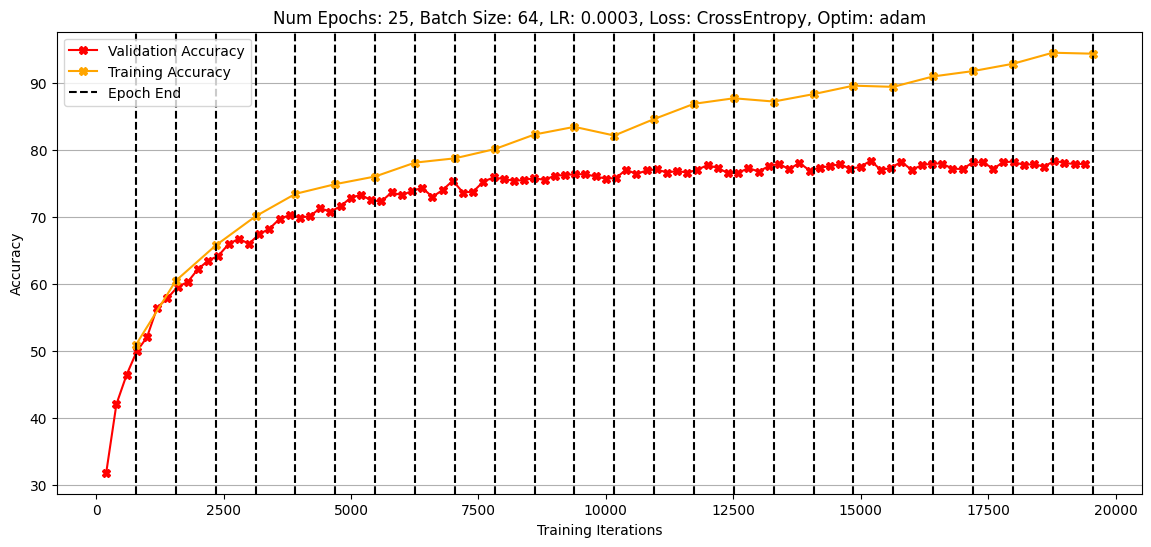

In [20]:
plt.figure(figsize=(14,6))
plt.plot(val_iterations, validation_accuracy_per_iteration , label="Validation Accuracy", marker = "X", color="red")
plt.plot([len(trainloader)*(i+1) for i in range(NUM_EPOCHS)], training_accuracy_vs_epoch, label="Training Accuracy", marker = "X", color="Orange")
for i in range(NUM_EPOCHS):
  label = ("Epoch End" if i == NUM_EPOCHS - 1 else None )
  plt.axvline(len(trainloader)*(i+1), 0, 100, color="black", ls = "--", label=label)
plt.xlabel("Training Iterations")
plt.ylabel("Accuracy")
plt.title(f"Num Epochs: {NUM_EPOCHS}, Batch Size: {BATCH_SIZE}, LR: {LEARNING_RATE}, Loss: {LOSS_FUNCTION}, Optim: {OPTIMIZER}")
plt.gca().yaxis.grid(True)
plt.legend()

In [21]:
def class_wise_accuracy(model, dataloader):
  model.eval()
  total_cnt = [0 for _ in range(NUM_CLASSES)]
  correct_cnt = [0 for _ in range(NUM_CLASSES)]

  for batch_idx, data in enumerate(dataloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        pred = torch.argmax(logits, dim=1)
        for idx in range(images.shape[0]):
          ### iterate over each sample in the dataset
          total_cnt[labels[idx]] += 1
          correct_cnt[labels[idx]] += 1 if (pred[idx] == labels[idx]) else 0

  accuracy = [correct/total*100 for (correct, total) in (zip(correct_cnt, total_cnt))]

  for idx in range(NUM_CLASSES):
    print(classes[idx], f"{accuracy[idx]:.2f}%")

print("CLASS WISE ACCURACY FOR TRAIN")
class_wise_accuracy(model, trainloader)

print("CLASS WISE ACCURACY FOR TEST")
class_wise_accuracy(model, testloader)

CLASS WISE ACCURACY FOR TRAIN
plane 98.80%
car 97.94%
bird 89.28%
cat 85.36%
deer 96.04%
dog 87.52%
frog 97.98%
horse 97.96%
ship 94.58%
truck 98.70%
CLASS WISE ACCURACY FOR TEST
plane 86.40%
car 87.40%
bird 65.50%
cat 56.50%
deer 76.20%
dog 69.00%
frog 86.10%
horse 82.20%
ship 80.60%
truck 87.80%


TO DO

1.   Loss Curves
2.   Different Set of Optimizers
3.   Learning Rate Schedulers
4.   Class Wise Accuracy
5.   Different Loss functions
6.   Data Augmentation

